В данном ноутбуке я для начала делаю обработку текста и строю облако, чтобы посмотреть наиболее частовстречающиеся слова в колонке с текстом. Также, в ходе работы я рассматриваю несколько моделей: пайпланы с TF-IDF векторайзером и четырьмя различными моделями: линейная модель стохастического градиентного спуска; knn-классификатор; наивный байесовский классификатор; лог регрессия.

Далее я рассматриваю в качестве токенайзера nltk и логрег, так как он лучше всего себя показал по результатам roc-auc на валидационной выборке.

Далее вы можете увидеть BERT токенайзер + логрег

И в заключении небольшая НС LSTM на основе keras также с одним из лучших результатов roc-auc на валидационной выборке.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import pandas as pd
df= pd.read_csv('/content/drive/MyDrive/1train_spam.csv')

In [ ]:
df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [ ]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Axes: >

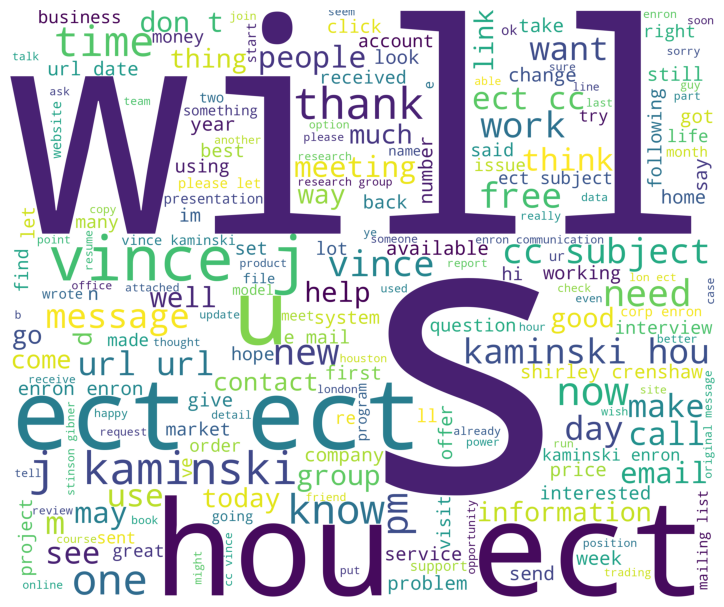

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus
# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus
# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

corpus = get_corpus(df['text'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

In [ ]:
df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

# **Pipelines**

In [47]:
df_new=df.copy()
df_new['text_type'] = df['text_type'].map({'spam': 1, 'ham': 0})

In [ ]:
df_new.head()

,text_type,text
0,0,make sure alex knows his birthday is over in f...
1,0,a resume for john lavorato thanks vince i will...
2,1,plzz visit my website moviesgodml to get all m...
3,1,urgent your mobile number has been awarded wit...
4,0,overview of hr associates analyst project per ...


In [31]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(df_new['text'], df_new['text_type'], test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('sgd_clf', SGDClassifier(loss='log_loss', random_state=42))])
knb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knb_clf', KNeighborsClassifier(n_neighbors=10))])
nb_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb_clf', MultinomialNB())
])
logreg_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg_clf', LogisticRegression(random_state=42))
])
logreg_ppl_clf.fit(X_train, y_train)
nb_ppl_clf.fit(X_train, y_train)
sgd_ppl_clf.fit(X_train, y_train)
knb_ppl_clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('knb_clf', KNeighborsClassifier(n_neighbors=10))])

В связи с тем, что датасет не сбалансирован, метрику «accuracy» (доля верных ответов) использовать нельзя, так как это приведет к завышенной оценке качества работы классификатора. В данном случае самое правильное – считать сразу несколько метрик, устойчивых к распределению классов (в данном случае, это — точность, полнота и f-мера) и смотреть на них все. Однако часто бывает удобно получить не большой набор цифр, а одно число, по которому можно понять, насколько хорошо модель работает. В нашей задаче лучше всего подходит «macro-avg» (сначала подсчитывается каждая метрика по каждому классу, а потом усредняется). Macro-avg более устойчива к скошенным распределениям классов.

In [ ]:
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2085
           1       0.88      0.91      0.90       845

    accuracy                           0.94      2930
   macro avg       0.92      0.93      0.93      2930
weighted avg       0.94      0.94      0.94      2930



In [ ]:
predicted_knb = knb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_knb, y_test))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84      2847
           1       0.09      0.98      0.17        83

    accuracy                           0.73      2930
   macro avg       0.55      0.85      0.50      2930
weighted avg       0.97      0.73      0.82      2930



In [ ]:
predicted_nb = nb_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_nb, y_test))

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2422
           1       0.55      0.94      0.69       508

    accuracy                           0.86      2930
   macro avg       0.77      0.89      0.80      2930
weighted avg       0.91      0.86      0.87      2930



In [ ]:
predicted_logreg = logreg_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_logreg, y_test))

              precision    recall  f1-score   support

           0       0.97      0.92      0.95      2161
           1       0.81      0.92      0.86       769

    accuracy                           0.92      2930
   macro avg       0.89      0.92      0.91      2930
weighted avg       0.93      0.92      0.93      2930



Линейный классификатор показал лучший результат на тестовых данных (0,93 против 0,5 у классификатора методом ближайших соседей и против 0,8 у наивного байесовского), поэтому для дальнейшей настройки модели будем использовать его.

In [ ]:
sgd_ppl_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=42))])
sgd_ppl_clf.fit(X_train, y_train)
predicted_sgd = sgd_ppl_clf.predict(X_test)
print(metrics.classification_report(predicted_sgd, y_test))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1989
           1       0.94      0.88      0.91       941

    accuracy                           0.94      2930
   macro avg       0.94      0.93      0.93      2930
weighted avg       0.94      0.94      0.94      2930



In [ ]:
predicted_sgd_val = sgd_ppl_clf.predict(X_valid)
print(metrics.classification_report(predicted_sgd_val, y_valid))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1126
           1       0.93      0.84      0.88       502

    accuracy                           0.93      1628
   macro avg       0.93      0.91      0.92      1628
weighted avg       0.93      0.93      0.93      1628



In [ ]:
proba_sgd_val = sgd_ppl_clf.predict_proba(X_valid)[:, 1]


from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_sgd_val)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.975651799181211


In [ ]:
proba_logreg_val = logreg_ppl_clf.predict_proba(X_valid)[:, 1]

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_logreg_val)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9767497634505308


In [ ]:
proba_knb_val = knb_ppl_clf.predict_proba(X_valid)[:, 1]


from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_knb_val)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9183412495432957


In [ ]:
proba_nb_val = nb_ppl_clf.predict_proba(X_valid)[:, 1]


from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_nb_val)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.9285311448994313


# **nltk tokenizer**

nltk токенайзер + логрег

In [ ]:
df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [34]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
stop_words = stopwords.words('english')

class NLTKTokenizer(object):
    def __call__(self, doc):
        return word_tokenize(doc)

tfidf_nltk = TfidfVectorizer(tokenizer=NLTKTokenizer(), stop_words=stop_words)
logreg_ppl_clf = Pipeline([
    ('tfidf', tfidf_nltk),
    ('logreg_clf', LogisticRegression(random_state=42))
])
logreg_ppl_clf.fit(X_train, y_train)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...],
                                 tokenizer=<__main__.NLTKTokenizer object at 0x7e563d9e4460>)),
                ('logreg_clf', LogisticRegression(random_state=42))])

In [62]:
proba_logreg_nltk_val = logreg_ppl_clf.predict_proba(X_valid)[:, 1]  # скоры для спама

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_logreg_nltk_val)
print(f"ROC-AUC Score: {roc_auc}")

ROC-AUC Score: 0.97749547979727


In [64]:
len(proba_logreg_nltk_val)

1628

In [65]:
X_new = pd.read_csv('/content/drive/MyDrive/test_spam.csv')

In [66]:
ans_df_nltk= X_new.copy()

In [67]:
ans_df_nltk

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...
...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...
4066,baylor enron case study cindy yes i shall co a...
4067,boring as compared to tp
4068,hellogorgeous hows u my fone was on charge lst...


In [73]:
import pandas as pd

proba_logreg_nltk_test = logreg_ppl_clf.predict_proba(ans_df_nltk['text'])[:, 1]  # Получение вероятностей для  класса spam

results = pd.DataFrame({
    'text': ans_df_nltk['text'],
    'score': proba_logreg_nltk_test

})

results.to_csv('test_scores_nltk.csv', index=False)


In [71]:
len(proba_logreg_nltk_test)

4070

In [77]:
results[10:]

,text,score
10,k fyi x has a ride early tomorrow morning but ...,0.040560
11,in a message dated 1635465 1635465 1635465 163...,0.067956
12,is your business making money set up to accept...,0.829779
13,blaming regex,0.187341
14,mum ive sent you many many messages since i go...,0.076187
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,0.181236
4066,baylor enron case study cindy yes i shall co a...,0.002098
4067,boring as compared to tp,0.216140
4068,hellogorgeous hows u my fone was on charge lst...,0.025729


# **BERT tokenizer**

берт+логрег

In [78]:
from sklearn.base import TransformerMixin, BaseEstimator
from transformers import DistilBertTokenizer, DistilBertModel
import torch

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')
class DistilBertEmbedder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        with torch.no_grad():
            return torch.stack([
                model(**tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)).last_hidden_state[:,0].squeeze()
                for text in X
            ]).numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
logreg_ppl_clf = Pipeline([
    ('distilbert_emb', DistilBertEmbedder()),
    ('logreg_clf', LogisticRegression(random_state=42))
])
logreg_ppl_clf.fit(X_train, y_train)


In [ ]:
proba_logreg_bert_val = logreg_ppl_clf.predict_proba(X_valid)[:, 1]

from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_valid, proba_logreg_bert_val)
print(f"ROC-AUC Score: {roc_auc}")

In [ ]:
test_data= pd.read_csv('/content/drive/MyDrive/test_spam.csv')

In [ ]:
preds= logreg_ppl_clf.predict_proba(test_data)[:, 1]

# **keras lstm**

создадим небольшой классификатор LSTM.  LSTM используется для моделирования последовательных данных, таких как тексты или временные ряды.

In [3]:
X_new = pd.read_csv('/content/drive/MyDrive/test_spam.csv')

In [4]:
ans_df= X_new.copy()

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score


X = df['text']
y = df['text_type']
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

max_features = 10000
maxSequenceLength = 100
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

X_valid = tokenizer.texts_to_sequences(X_valid)
X_valid = sequence.pad_sequences(X_valid, maxlen=maxSequenceLength)

X_train = sequence.pad_sequences(X_train, maxlen=maxSequenceLength)
X_test = sequence.pad_sequences(X_test, maxlen=maxSequenceLength)

X_new = X_new['text']
X_new = tokenizer.texts_to_sequences(X_new)
X_new = sequence.pad_sequences(X_new, maxlen=maxSequenceLength)

num_classes = len(np.unique(y))

model = Sequential()
model.add(Embedding(max_features, maxSequenceLength))
model.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [6]:
batch_size = 32
epochs = 3
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(X_test, y_test))


Epoch 1/3
367/367 [==============================] - 116s 295ms/step - loss: 0.2707 - accuracy: 0.8905 - val_loss: 0.1647 - val_accuracy: 0.9444
Epoch 2/3
367/367 [==============================] - 58s 159ms/step - loss: 0.1067 - accuracy: 0.9656 - val_loss: 0.1571 - val_accuracy: 0.9447
Epoch 3/3
367/367 [==============================] - 58s 159ms/step - loss: 0.0580 - accuracy: 0.9828 - val_loss: 0.1664 - val_accuracy: 0.9454


In [7]:
proba_lstm_test = model.predict(X_valid)

roc_auc = roc_auc_score(y_valid, proba_lstm_test)
print(f"ROC-AUC Score: {roc_auc}")

51/51 [==============================] - 1s 16ms/step
ROC-AUC Score: 0.9811228839361832


In [13]:
len(ans_df['text'])

4070

In [ ]:
preds=model.predict(X_new)

ans_df['score'] = preds
ans_df.to_csv('test_scores_lstm.csv', index=False)

In [ ]:
ans_df

In [ ]:
preds